In [1]:
import os
import sys

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pytorch3d.transforms import euler_angles_to_matrix, matrix_to_euler_angles, random_rotation

In [2]:
# config
MAX_DEPTH = 10.
IMG_WIDTH = 640
IMG_HEIGHT = 640
FOCAL_LENGTH = 75
MIN_DEPTH = 0.1
MAX_DEPTH = 10

In [3]:
dtype = torch.float64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# x
def get_roll_mtx(roll: float, device: torch.device, dtype: torch.dtype):
    roll = torch.tensor(roll)
    return torch.tensor([[1., 0., 0.],
                           [0., torch.cos(roll), -torch.sin(roll)],
                           [0., torch.sin(roll), torch.cos(roll)]],
                         dtype=dtype, 
                         device=device) 

# y
def get_pitch_mtx(pitch: float, device: torch.device, dtype: torch.dtype):
    pitch = torch.tensor(pitch)
    return torch.tensor([[torch.cos(pitch), 0., torch.sin(pitch)],
                           [0., 1., 0.],
                           [-torch.sin(pitch), 0., torch.cos(pitch)]],
                         dtype=dtype)

# z
def get_yaw_mtx(yaw: float, device: torch.device, dtype: torch.dtype):
    yaw = torch.tensor(yaw)
    return torch.tensor([[torch.cos(yaw), -torch.sin(yaw), 0.],
                           [torch.sin(yaw), torch.cos(yaw), 0.],
                           [0., 0., 1.]],
                         dtype=dtype)

# x, y, z
def get_rt_mtx(roll: float, pitch: float, yaw: float,
               device: torch.device, dtype: torch.dtype):
    RX = get_roll_mtx(roll, device, dtype)
    RZ = get_yaw_mtx(yaw, device, dtype)
    RY = get_pitch_mtx(pitch, device, dtype)

    R = torch.mm(RZ, RY)
    R = torch.mm(R, RX)

    return R

def get_upward_with_dev(rot: float, x_dev: float, z_dev: float,
                        device: torch.device = torch.device('cpu'),
                        dtype: torch.dtype = torch.float64):
    return get_rt_mtx(x_dev, rot, z_dev, device, dtype)

In [15]:
def get_random_upward(x_dev: float = 0., z_dev: float = 0.):
    random_angle = torch.randint(high=90, size=(1,)).float()
    return get_upward_with_dev(float(random_angle), x_dev, z_dev), random_angle

def rand_rot_mtx():
    roll = torch.randint(high=90, size=(1,)).to(torch.float64)
    yaw = torch.randint(high=90, size=(1,)).to(torch.float64)
    pitch = torch.randint(high=90, size=(1,)).to(torch.float64)
    return get_rt_mtx(roll, pitch, yaw)

In [6]:
def _generate_example(R, t):
    # create homogeneous point in 2d
    x1, x2 = torch.rand(3, dtype=torch.float64), torch.rand(3, dtype=torch.float64)
    x1[2], x2[2] = 1., 1.
    
    rdepth = torch.rand(1) * MAX_DEPTH

    X1, X2 = R @ (x1 * rdepth) + t, R @ (x2 * rdepth) + t

    return x1, x2, X1, X2 

In [16]:
def generate_examples(num_of_examples: int, dev: tuple[float, float] = (0., 0.)):
    R, rand_angle = get_random_upward(*dev)
    t = torch.rand(3, )
        
    xs, Xs = [], []
    for i in range(num_of_examples):
        x1, x2, X1, X2 = _generate_example(R, t)
        xs.append((x1, x2))
        Xs.append((X1, X2))
            
    return xs, Xs, R, t, rand_angle

In [17]:
from solver import Up2P
def assert_correctness():
    solver = Up2P()
    xs, Xs, Rg, tg, _ = generate_examples(1)
    print(Rg, tg)
    xs, Xs = xs[0], Xs[0]
    for R, t in solver(torch.stack(xs), torch.stack(Xs)):
        re, te = Up2P.validate_sol(R, t, Rg, tg)
        print(f"--------- R error: {re.float()}, t error: {te.float()} ----------")            
        
assert_correctness()

tensor([[ 0.4401,  0.0000, -0.8979],
        [ 0.0000,  1.0000,  0.0000],
        [ 0.8979,  0.0000,  0.4401]], dtype=torch.float64) tensor([0.2564, 0.4759, 0.4329])
--------- R error: 6.688883047445415e-08, t error: 7.258286416345072e-08 ----------
--------- R error: 1.0229829549789429, t error: 1.1100661754608154 ----------


In [39]:
import random
import itertools

# X : (3, )
# R : (3, 3) - rotation matrix
# t : (3, ) - translation vector
def reproject(X, R, t):
    translated = R.T @ (X - t)
    translated[:2] /= translated[2]
    translated[2] = 1.
    
    return translated

def get_displacements(n: int = 52, dev: tuple[float, float] = (0, 0)):
    solver = Up2P()
    
    xs, Xs, Rg, tg, rand_angle = generate_examples(n, dev)
    
    sols = []
    while len(sols) == 0:
        solve_for = random.randint(0, len(xs) - 1)
        sols = solver(torch.stack(xs[solve_for]), torch.stack(Xs[solve_for]))
    
    validate_for = None
    while validate_for is None or validate_for == solve_for:
        validate_for = random.randint(0, len(xs) - 1)
    
    
    R, t, err = None, None, None
    for sol in sols:
        Rc, tc = sol
        reprojected_x = reproject(Xs[validate_for][0], Rc, tc)
        gt_x = xs[validate_for][0]
        if err is None or (gt_x - reprojected_x).norm() < err:
            err = (gt_x - reprojected_x).norm()
            R, t = Rc, tc
            
    reprojected_x = reproject(Xs[validate_for][0], R, t)
    gt_x = xs[validate_for][0]
    # assert (gt_x - reprojected_x).norm() < 1e-3
    
    gt, proj = [], []
    for idx in range(len(Xs)):
        if idx == solve_for or idx == validate_for:
            continue
            
        for j in range(2):
            X, x = Xs[idx][j], xs[idx][j]
            reprojected_x = reproject(X, R, t)
            # displacements.append(x[:2] - reprojected_x[:2])
            gt.append(x[:2])
            proj.append(reprojected_x[:2])
        
    return gt, proj, rand_angle

In [71]:
def plot_displacements(gt, proj):
    X = [elm[0] for elm in gt]
    Y = [elm[1] for elm in gt]
    U = [elm[0] for elm in proj]
    V = [elm[1] for elm in proj]
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), dpi=80)
    axes.quiver(X, Y, U, V,
                           color='r',
                           units='xy',
                           scale=1,
                           width=0.01
                          )
    
    axes.quiver(np.mean(X), np.mean(Y), np.mean(U), np.mean(V),
                           color='b',
                           units='xy',
                           scale=1,
                           width=0.01
                          )
    # axes.set_xlim(-640, 640)
    # axes.set_ylim(-640, 640)
    axes.set_xlim(-5, 5)
    axes.set_ylim(-5, 5)
    # fig.suptitle(path, fontsize=16)
    # fig.tight_layout()
    
    plt.show()

y angle is:  tensor([6.])


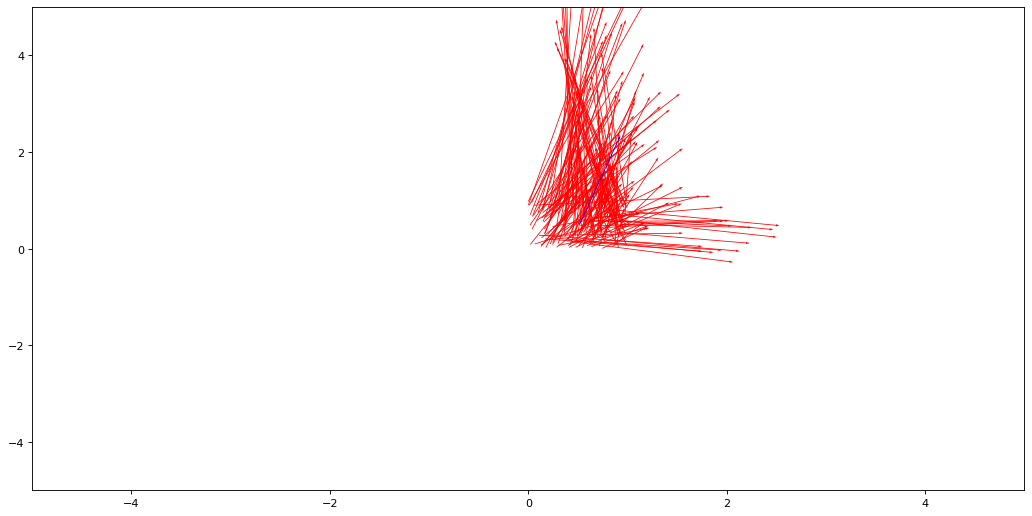

In [79]:
gt, proj, y_angle = get_displacements(100, (15,  0))
print("y angle is: ", y_angle)
plot_displacements(gt, proj)